# Universidade Federal de Alagoas - Instituto de Computação
## **1a lista de exercícios**


---

Alunos: Anderson Clemente, Ester de Lima.

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive/', force_remount=True)
from google.colab.patches import cv2_imshow
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from collections import deque
import random
import string


Mounted at /content/gdrive/


In [ ]:
sourcePath = "/content/gdrive/MyDrive/8º Periodo/Visão computacional/sources/"

1. Implemente uma função que receba uma imagem em formato PPM,
o tamanho n de um filtro espacial com dimensões $n × n$ e a matriz com os
pesos do filtro, e aplique o filtro com uma convolução, gerando e salvando a
imagem resultante no disco em formato PPM. Você não pode usar a OpenCV
em nenhum desses passos. As especificações do formato PPM podem ser encontradas aqui: https://netpbm.sourceforge.net/doc/ppm.html

In [ ]:
fileName = {1: 'feep.ascii.ppm', 2: 'star_field.ascii.ppm', 3: 'blackbuck.ascii.ppm'}
fullpath = sourcePath+fileName[1]

In [ ]:
#Peeking img structure
imgBinary =  open(fullpath, 'r')
Lines = imgBinary.readlines()
count = 0
# Strips the newline character
for line in Lines:
    count += 1
    print("Line{}: {}".format(count, line.strip()))

def openPpm(fullpath):
  imgBinary =  open(fullpath, 'r')
  Lines = imgBinary.readlines()
  return Lines
  # Strips the newline character

def peakImg(Lines):
  count = 0
  for line in Lines:
      count += 1
      print("Line{}: {}".format(count, line.strip()))

Line1: P3
Line2: # feep.ppma
Line3: 4 4
Line4: 15
Line5: 0  0  0  0  0  0    0  0  0   15  0 15
Line6: 0  0  0  0 15  7    0  0  0    0  0  0
Line7: 0  0  0  0  0  0    0 15  7    0  0  0
Line8: 15  0 15  0  0  0    0  0  0    0  0  0


In [ ]:
def formImg(Lines):
  if 'P3' not in Lines[0]:
    return [], 0
  else:
    index = 1
    maxIndex = 2
    while index < maxIndex:
      if '#' in Lines[index]:
        index += 1
        maxIndex += 1
      else:
        imgSize = [int(x) for x in Lines[index].split()]
        index += 1
        maxValue = int(Lines[index])
    imgBuffer = []
    for i in range(index+1, len(Lines)):
      row = [int(x) for x in Lines[i].split()]
      imgBuffer += row
    img = np.zeros((int(imgSize[0]), int(imgSize[1])), dtype=object)
    index = 0
    for row in range(int(imgSize[0])):
      for col in range(int(imgSize[1])):
        pixel = (imgBuffer[index], imgBuffer[index+1], imgBuffer[index+2])
        index += 3
        img[row, col] = pixel
    print(f'img processed, size readed: {imgSize}, size writed {img.shape}, max value {maxValue}')
    return img, maxValue


# img, maxValue = formImg(Lines)

In [ ]:
def stripChannels(img):
  red = np.zeros((img.shape[0], img.shape[1]))
  blue = np.zeros((img.shape[0], img.shape[1]))
  green = np.zeros((img.shape[0], img.shape[1]))
  for row in range(img.shape[0]):
    for col in range(img.shape[1]):
      red[row][col] = img[row][col][0]
      blue[row][col] = img[row][col][1]
      green[row][col] = img[row][col][2]
  return red, blue, green

# redimg, blueimg, greenimg = stripChannels(img)


In [ ]:
def joinChannels(redChannel, blueChannel, greenChannel):
  if redChannel.shape == blueChannel.shape == greenChannel.shape:
    output = np.empty((redChannel.shape[0], redChannel.shape[1]), dtype='object')
    for row in range(redChannel.shape[0]):
      for col in range(redChannel.shape[1]):
          output[row, col] = (redChannel[row][col], blueChannel[row][col], greenChannel[row][col])
    return output
  else:
    return "invalid channels"

In [ ]:
def ppmConvolve(image, kernel, strides=1, padding=0):
  kernel = np.flipud(np.fliplr(kernel))

  xImgShape = image.shape[0]
  yImgShape = image.shape[1]
  xKernShape = kernel.shape[0]
  yKernShape = kernel.shape[1]

  xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
  yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
  output = np.zeros((xOutput, yOutput))

  if padding != 0:
      imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
      imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
  else:
      imagePadded = image

  for y in range(image.shape[1]):
      if y > image.shape[1] - yKernShape:
          break
      if y % strides == 0:
          for x in range(image.shape[0]):
              if x > image.shape[0] - xKernShape:
                  break
              try:
                  if x % strides == 0:
                    output[x][y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
              except:
                  break
  return output

In [ ]:
def convolve2D(imgSource, kernel, strides=1, padding=0):
  print(f'reading from: {imgSource}')
  fileLines = openPpm(imgSource)
  imgMatrix, maxValue = formImg(fileLines)
  redLayer, blueLayer, greenLayer = stripChannels(imgMatrix)

  convolvedRed =  ppmConvolve(redLayer, kernel, strides=1, padding=0)
  convolvedBlue = ppmConvolve(blueLayer, kernel, strides=1, padding=0)
  convolvedGreen =  ppmConvolve(greenLayer, kernel, strides=1, padding=0)

  convolvedImg = joinChannels(convolvedRed, convolvedBlue, convolvedGreen)
  # convolvedImg = joinChannels(redLayer, blueLayer, greenLayer)
  return convolvedImg

In [ ]:
def saveToFile(img, filename = 'img_teste'):
  path = '/content/gdrive/MyDrive/8º Periodo/Visão computacional/'
  if 'ppm' not in filename:
    filename += '.ppm'
  with open(f'{path}{filename}', 'w') as file:
    # file.write('P3\n')
    maxValue = 0
    header = f'P3\n{img.shape[0]} {img.shape[1]}\n'
    pixels = f''
    for row in range(img.shape[0]):
      for col in range(img.shape[1]):
        if img[row][col][0] > maxValue:
          maxValue = img[row][col][0]
        elif img[row][col][1] > maxValue:
          maxValue = img[row][col][1]
        elif img[row][col][2] > maxValue:
          maxValue = img[row][col][2]
        pixels += f'{int(max(img[row][col][0], 0))} {int(max(img[row][col][1], 0))} {int(max(img[row][col][2], 0))}\n'
    file.write(header + f'{int(maxValue)}\n' + pixels)
  file.close()
  print(f'saved as: {path}{filename}')


2. Usando a função da questão 1, implemente dois tipos de filtro para
remoção de ruídos e aplique-os em três imagens distintas.

In [ ]:
def applyFilter(imgPath, filterType, n=3, sigma = 1):
  # n: kernel dimensions
  if n % 2 == 0:
        return "Kernel dimensions must be odd. "
    
  kernel = np.zeros((n,n)).astype(float)

  if filterType == 'mean':
    kernel = np.zeros((n,n)).astype(float) + 1.0
    kernel = kernel * 1/(n*n)

  if filterType == 'gaussian':
    x, y = np.meshgrid(np.linspace(-n/2, n/2, n), np.linspace(-n/2, n/2, n))
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)

  finalMatrix = convolve2D(imgPath, kernel)
  return finalMatrix


In [ ]:
folderPath = '/content/gdrive/MyDrive/8º Periodo/Visão computacional/'
fileName = {1: 'feep.ascii.ppm', 2: 'blackbuck.ascii.ppm', 3: 'star_field.ascii.ppm'}
fullpath = sourcePath + fileName[1]

print('imagem original: ')
img = cv2.imread(fullpath)
cv2_imshow(img)
print('\nmean filter: ')
filteredImg = applyFilter(fullpath, 'mean', n = 3)
saveToFile(filteredImg, 'teste_mean')
filtered_mean = cv2.imread(folderPath+'teste_mean.ppm')
cv2_imshow(filtered_mean)
print('\nGaussian filter: ')
filteredImg = applyFilter(fullpath, 'gaussian', n = 3, sigma = 3)
saveToFile(filteredImg, 'teste_Gaussian')
filtered_gaussian = cv2.imread(folderPath+'teste_Gaussian.ppm')
cv2_imshow(filtered_gaussian)

imagem original: 



mean filter: 
reading from: /content/gdrive/MyDrive/8º Periodo/Visão computacional/sources/feep.ascii.ppm
img processed, size readed: [4, 4], size writed (4, 4), max value 15
saved as: /content/gdrive/MyDrive/8º Periodo/Visão computacional/teste_mean.ppm



Gaussian filter: 
reading from: /content/gdrive/MyDrive/8º Periodo/Visão computacional/sources/feep.ascii.ppm
img processed, size readed: [4, 4], size writed (4, 4), max value 15
saved as: /content/gdrive/MyDrive/8º Periodo/Visão computacional/teste_Gaussian.ppm


imagem original: 


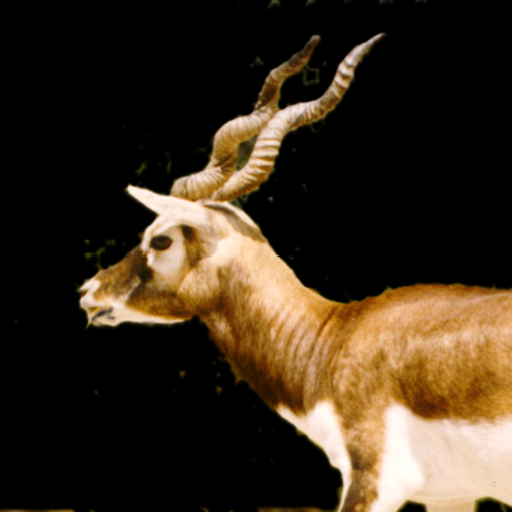


mean filter: 
reading from: /content/gdrive/MyDrive/8º Periodo/Visão computacional/sources/blackbuck.ascii.ppm
img processed, size readed: [512, 512], size writed (512, 512), max value 255
saved as: /content/gdrive/MyDrive/8º Periodo/Visão computacional/teste_mean.ppm


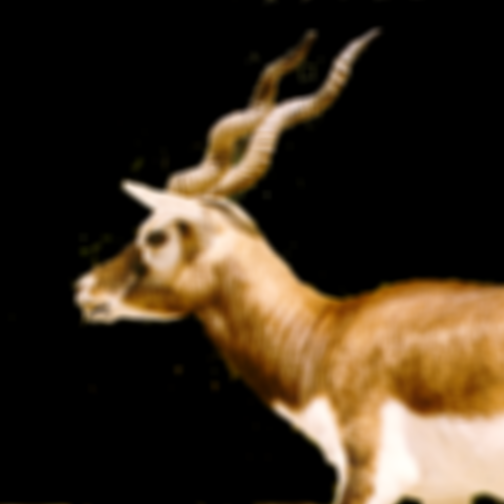


Gaussian filter: 
reading from: /content/gdrive/MyDrive/8º Periodo/Visão computacional/sources/blackbuck.ascii.ppm
img processed, size readed: [512, 512], size writed (512, 512), max value 255
saved as: /content/gdrive/MyDrive/8º Periodo/Visão computacional/teste_Gaussian.ppm


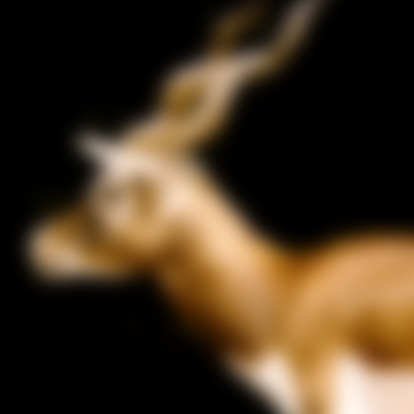

In [ ]:
folderPath = '/content/gdrive/MyDrive/8º Periodo/Visão computacional/'
fileName = {1: 'feep.ascii.ppm', 2: 'blackbuck.ascii.ppm', 3: 'star_field.ascii.ppm'}
fullpath = sourcePath + fileName[2]

print('imagem original: ')
img = cv2.imread(fullpath)
cv2_imshow(img)
print('\nmean filter: ')
filteredImg = applyFilter(fullpath, 'mean', n = 9)
saveToFile(filteredImg, 'teste_mean')
filtered_mean = cv2.imread(folderPath+'teste_mean.ppm')
cv2_imshow(filtered_mean)
print('\nGaussian filter: ')
filteredImg = applyFilter(fullpath, 'gaussian', n = 99, sigma = 10)
saveToFile(filteredImg, 'teste_Gaussian')
filtered_gaussian = cv2.imread(folderPath+'teste_Gaussian.ppm')
cv2_imshow(filtered_gaussian)



In [ ]:
folderPath = '/content/gdrive/MyDrive/8º Periodo/Visão computacional/'
fileName = {1: 'feep.ascii.ppm', 2: 'blackbuck.ascii.ppm', 3: 'star_field.ascii.ppm'}
fullpath = sourcePath + fileName[3]

print('imagem original: ')
img = cv2.imread(fullpath)
cv2_imshow(img)
print('\nmean filter: ')
filteredImg = applyFilter(fullpath, 'mean', n = 7)
saveToFile(filteredImg, 'teste_mean')
filtered_mean = cv2.imread(folderPath+'teste_mean.ppm')
cv2_imshow(filtered_mean)
print('\nGaussian filter: ')
filteredImg = applyFilter(fullpath, 'gaussian', n = 3, sigma = 4)
saveToFile(filteredImg, 'teste_Gaussian')
filtered_gaussian = cv2.imread(folderPath+'teste_Gaussian.ppm')
cv2_imshow(filtered_gaussian)

Output hidden; open in https://colab.research.google.com to view.

3. Usando a função da questão 1, pesquise um filtro passa-alta e
aplique-o em 3 imagens distintas, variando o valor de n em 3 unidades em
cada imagem. O que acontece quando n cresce?

O filtro high pass serve para filtrar as bordas da imagem. Percebemos que conforme o valor de n aumenta, maior fica a intensidade das bordas do objeto da imagem.

In [ ]:
def highPassFilter(imgPath, n=3):
  # n: kernel dimensions
  if n % 2 == 0:
        return "Kernel dimensions must be odd. "
    
  kernel = np.full((n, n), -1/(n*n))
  kernel[n//2, n//2] = (n*n-1)/(n*n)


  finalMatrix = convolve2D(imgPath, kernel)
  return finalMatrix

reading from: /content/gdrive/MyDrive/8º Periodo/Visão computacional/sources/blackbuck.ascii.ppm
img processed, size readed: [512, 512], size writed (512, 512), max value 255
saved as: /content/gdrive/MyDrive/8º Periodo/Visão computacional/teste_hp1.ppm
reading from: /content/gdrive/MyDrive/8º Periodo/Visão computacional/sources/blackbuck.ascii.ppm
img processed, size readed: [512, 512], size writed (512, 512), max value 255
saved as: /content/gdrive/MyDrive/8º Periodo/Visão computacional/teste_hp2.ppm
reading from: /content/gdrive/MyDrive/8º Periodo/Visão computacional/sources/blackbuck.ascii.ppm
img processed, size readed: [512, 512], size writed (512, 512), max value 255
saved as: /content/gdrive/MyDrive/8º Periodo/Visão computacional/teste_hp3.ppm


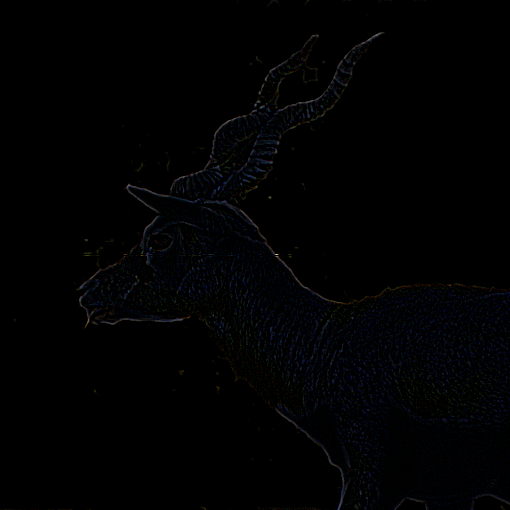

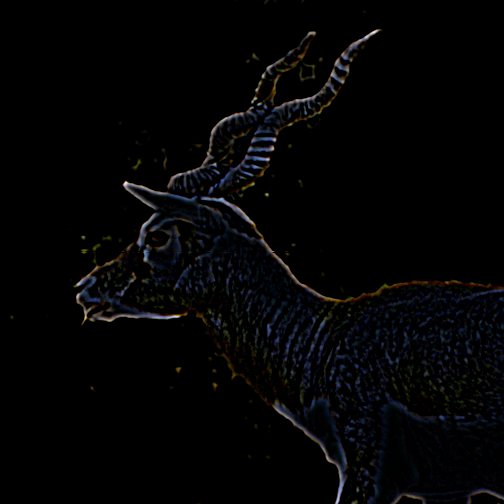

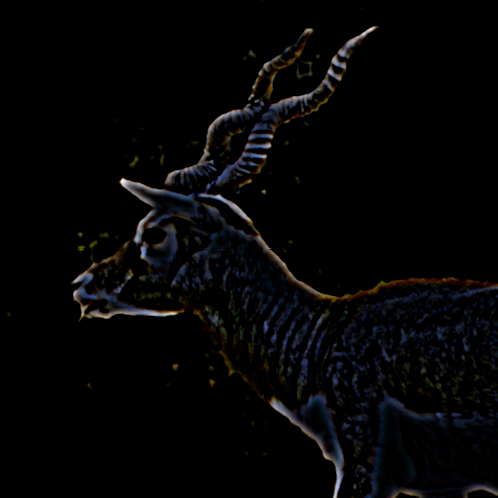

In [ ]:
folderPath = '/content/gdrive/MyDrive/8º Periodo/Visão computacional/'
fileName = {1: 'feep.ascii.ppm', 2: 'blackbuck.ascii.ppm', 3: 'star_field.ascii.ppm'}
fullpath = sourcePath + fileName[2]

filteredImg1 = highPassFilter(fullpath, n = 3)
saveToFile(filteredImg1, 'teste_hp1')
filteredImg2 = highPassFilter(fullpath, n = 9)
saveToFile(filteredImg2, 'teste_hp2')
filteredImg3 = highPassFilter(fullpath, n = 15)
saveToFile(filteredImg3, 'teste_hp3')

filtered_hp1 = cv2.imread(folderPath+'teste_hp1.ppm')
cv2_imshow(filtered_hp1)

filtered_hp2 = cv2.imread(folderPath+'teste_hp2.ppm')
cv2_imshow(filtered_hp2)

filtered_hp3 = cv2.imread(folderPath+'teste_hp3.ppm')
cv2_imshow(filtered_hp3)

4. Usando a função da questão 1, pesquise um filtro passa-baixa e
aplique-o em 3 imagens distintas, variando o valor de n em 3 unidades em
cada imagem. O que acontece quando n cresce?

Os filtros utilizados na questão 2 são filtros passa-baixa, podemos reutilizar as funções para comparar a intensidade de cada n. Percebemos que conforme o valor de n aumenta, maior fica a intensidade de suavização da imagem.

reading from: /content/gdrive/MyDrive/8º Periodo/Visão computacional/sources/blackbuck.ascii.ppm
img processed, size readed: [512, 512], size writed (512, 512), max value 255
saved as: /content/gdrive/MyDrive/8º Periodo/Visão computacional/teste_mean1.ppm
reading from: /content/gdrive/MyDrive/8º Periodo/Visão computacional/sources/blackbuck.ascii.ppm
img processed, size readed: [512, 512], size writed (512, 512), max value 255
saved as: /content/gdrive/MyDrive/8º Periodo/Visão computacional/teste_mean2.ppm
reading from: /content/gdrive/MyDrive/8º Periodo/Visão computacional/sources/blackbuck.ascii.ppm
img processed, size readed: [512, 512], size writed (512, 512), max value 255
saved as: /content/gdrive/MyDrive/8º Periodo/Visão computacional/teste_mean3.ppm


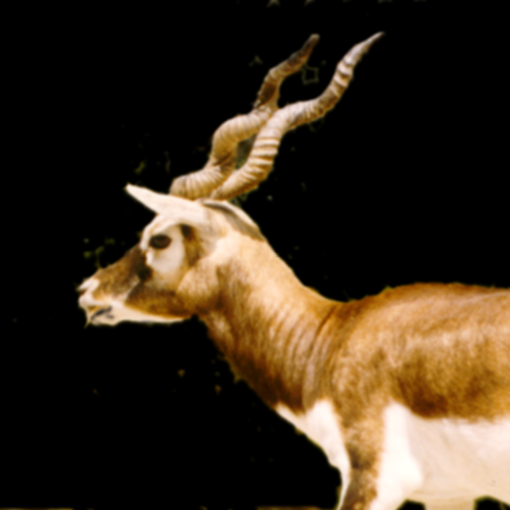

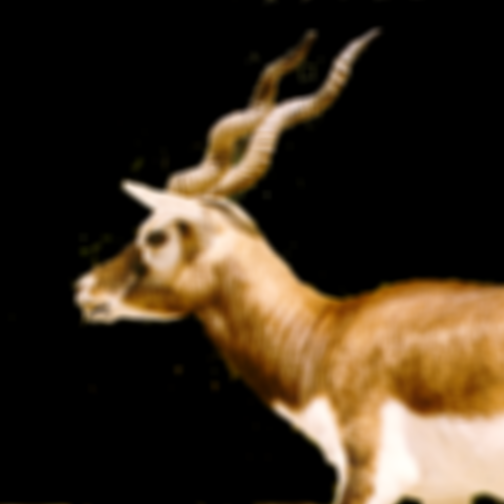

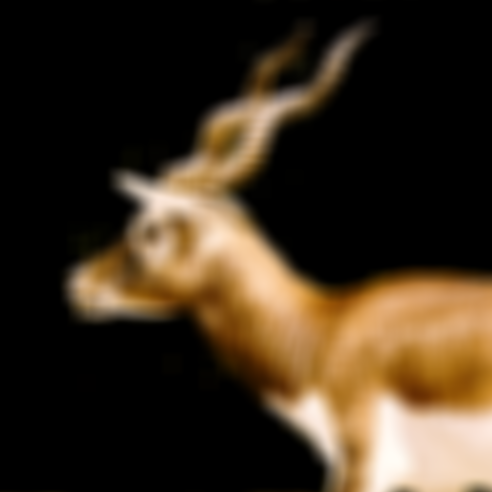

In [ ]:
folderPath = '/content/gdrive/MyDrive/8º Periodo/Visão computacional/'
fileName = {1: 'feep.ascii.ppm', 2: 'blackbuck.ascii.ppm', 3: 'star_field.ascii.ppm'}
fullpath = sourcePath + fileName[2]

filteredImg1 = applyFilter(fullpath, 'mean', n = 3, sigma = 1)
saveToFile(filteredImg1, 'teste_mean1')
filteredImg2 = applyFilter(fullpath, 'mean', n = 9, sigma = 1)
saveToFile(filteredImg2, 'teste_mean2')
filteredImg3 = applyFilter(fullpath, 'mean', n = 21, sigma = 1)
saveToFile(filteredImg3, 'teste_mean3')

filtered_mean1 = cv2.imread(folderPath+'teste_mean1.ppm')
cv2_imshow(filtered_mean1)

filtered_mean2 = cv2.imread(folderPath+'teste_mean2.ppm')
cv2_imshow(filtered_mean2)

filtered_mean3 = cv2.imread(folderPath+'teste_mean3.ppm')
cv2_imshow(filtered_mean3)

5. Aplique o detector de canny usando a função Canny() da OpenCV
em uma ou mais imagens de sua escolha. Experimente variar os parâmetros
threshold1, threshold2 e apertureSize. Explique com suas palavras a influência
de cada parâmetro no resultado.

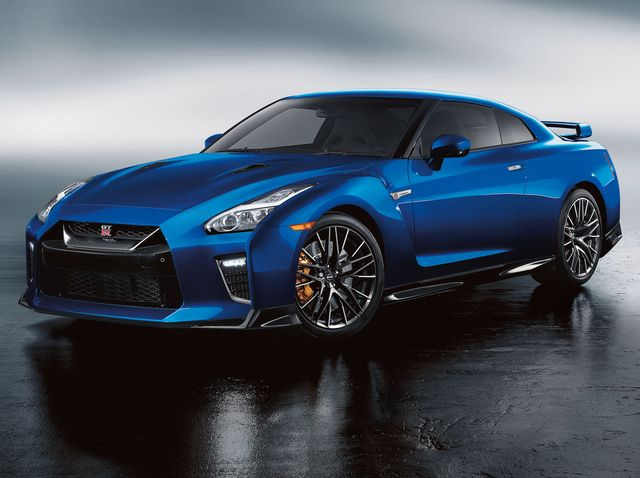

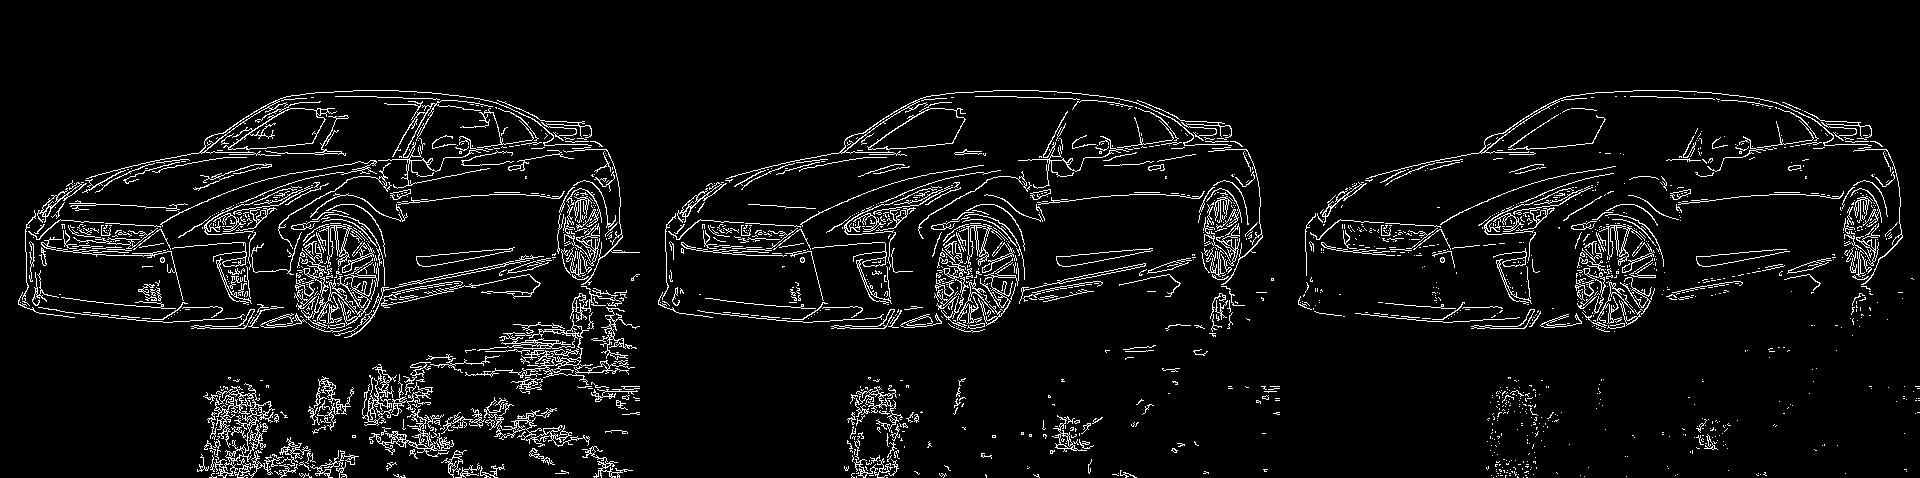

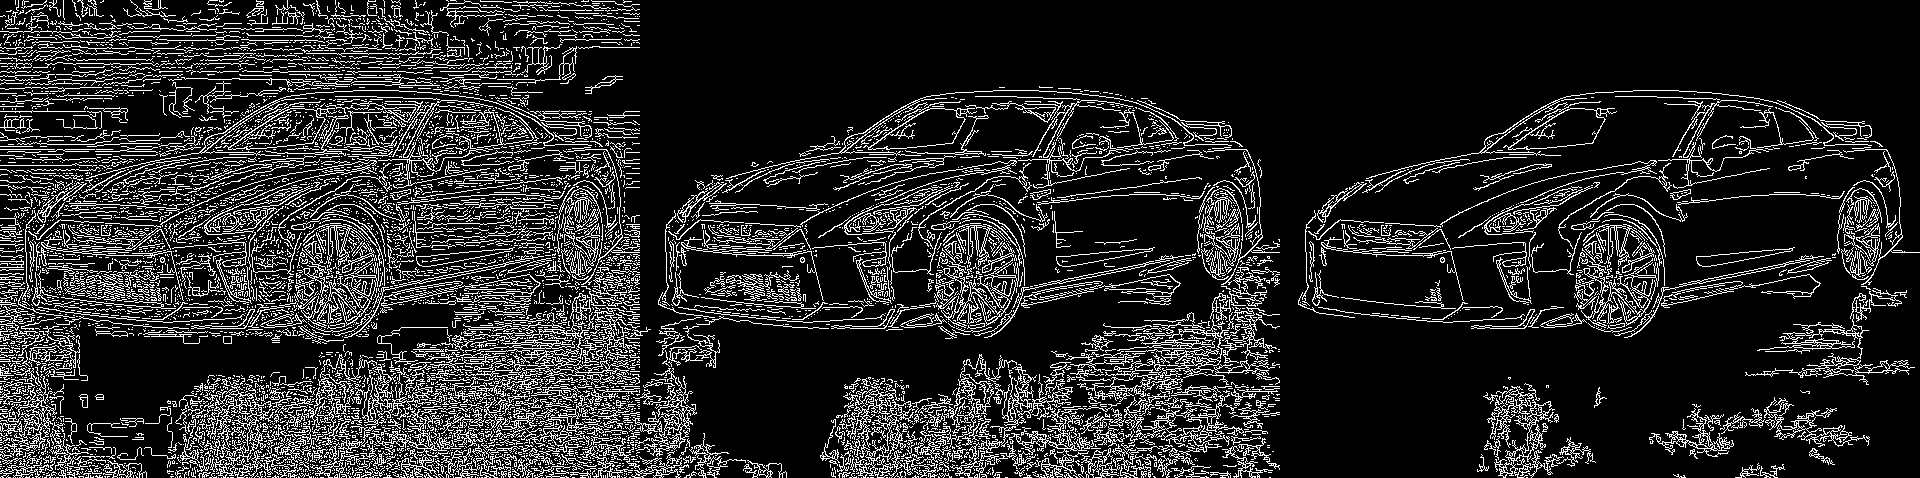

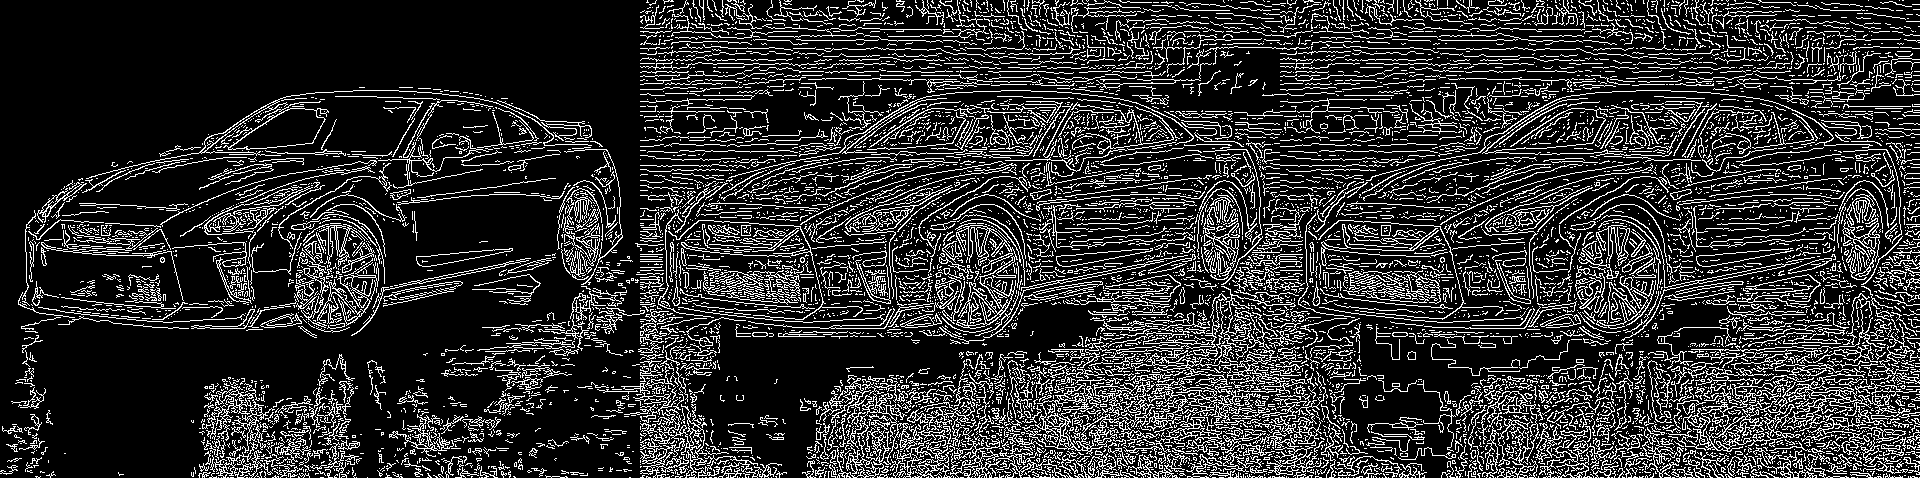

'\nPercebemos que:\nthreshold1 serve para identificar pixels de baixa intensidade, pois o reflexo do carro no chão foi detectado com baixo valor de threshold1\nthreshold2 serve para identificar pixels de alta intensidade, pois os contornos fortes do carro permanecem mesmo com valores altos de threshold2\napertureSize é utilizado para aumentar a sensibilidade de detalhes da imagem\n'

In [ ]:
nissanGTR = '2023-nissan-gtr.jpg'
img = cv2.imread(sourcePath+nissanGTR)
cv2_imshow(img)

#Variando o threshold1
edge = cv2.Canny(img, 1, 200,
                 apertureSize = 3 ) 
edge1 = cv2.Canny(img, 100, 200,
                 apertureSize = 3 ) 
edge2 = cv2.Canny(img, 199, 200,
                 apertureSize = 3 )

#Variando o threshold2
edge3 = cv2.Canny(img, 1, 10,
                 apertureSize = 3 ) 
edge4 = cv2.Canny(img, 1, 90,
                 apertureSize = 3 ) 
edge5 = cv2.Canny(img, 1, 240,
                 apertureSize = 3 )

#Variando apertureSize
edge6 = cv2.Canny(img, 50, 100,
                 apertureSize = 3 ) 
edge7 = cv2.Canny(img, 50, 100,
                 apertureSize = 5 ) 
edge8 = cv2.Canny(img, 50, 100,
                 apertureSize = 7 ) 

numpy_horizontal1 = np.hstack((edge, edge1, edge2))
cv2_imshow(numpy_horizontal1)

numpy_horizontal2 = np.hstack((edge3, edge4, edge5))
cv2_imshow(numpy_horizontal2)

numpy_horizontal3 = np.hstack((edge6, edge7, edge8))
cv2_imshow(numpy_horizontal3)

'''
Percebemos que:
threshold1 serve para identificar pixels de baixa intensidade, pois o reflexo do carro no chão foi detectado com baixo valor de threshold1
threshold2 serve para identificar pixels de alta intensidade, pois os contornos fortes do carro permanecem mesmo com valores altos de threshold2
apertureSize é utilizado para aumentar a sensibilidade de detalhes da imagem
'''


6. Implemente uma função que aumente a resolução da imagem por
um fator s, onde s é um inteiro maior que 1, usando a abordagem de vizinho mais próximo. Você sé pode usar o OpenCV para carregar a imagem. Aplique sua função em uma imagem, com 3 valores de s distintos.

tamanho original: 300x300


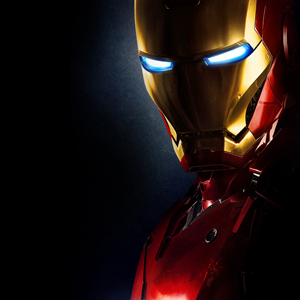

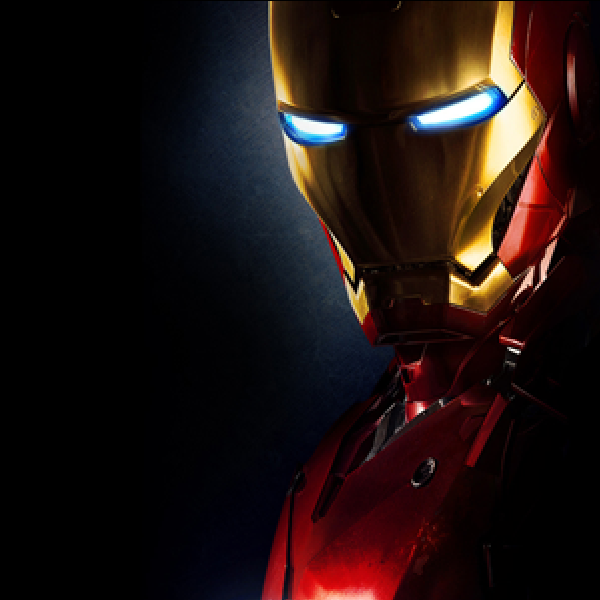

Ampliado 2x. Size: 600x600



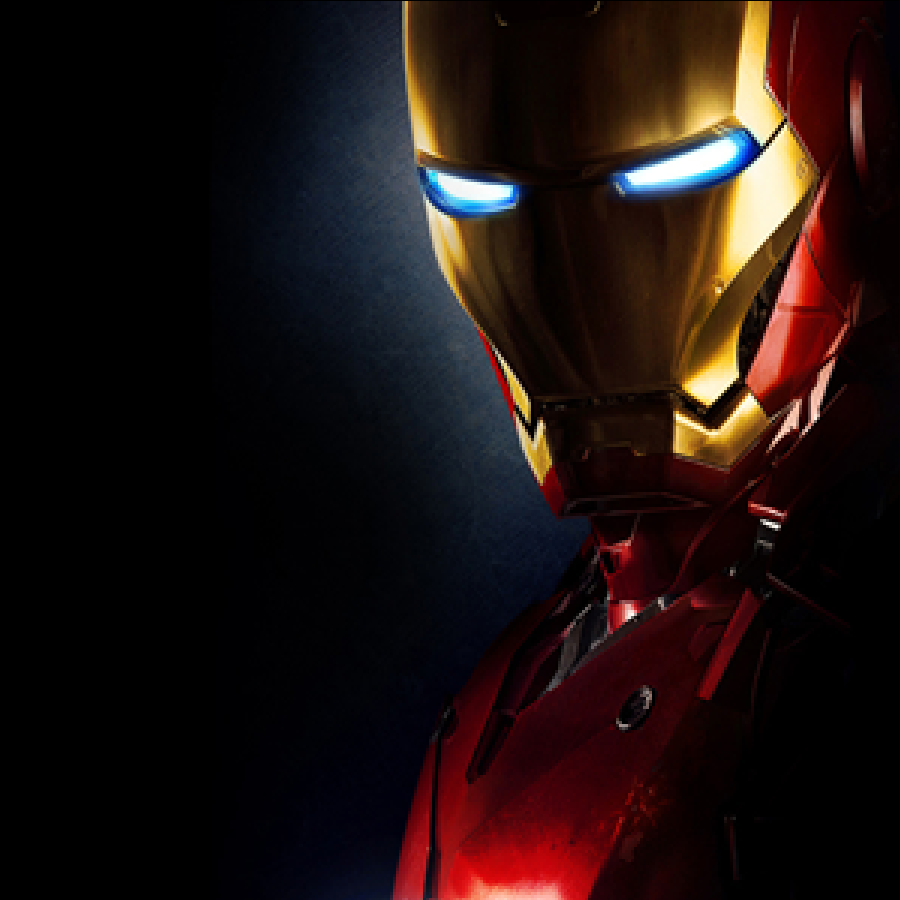

Ampliado 3x. Size: 900x900



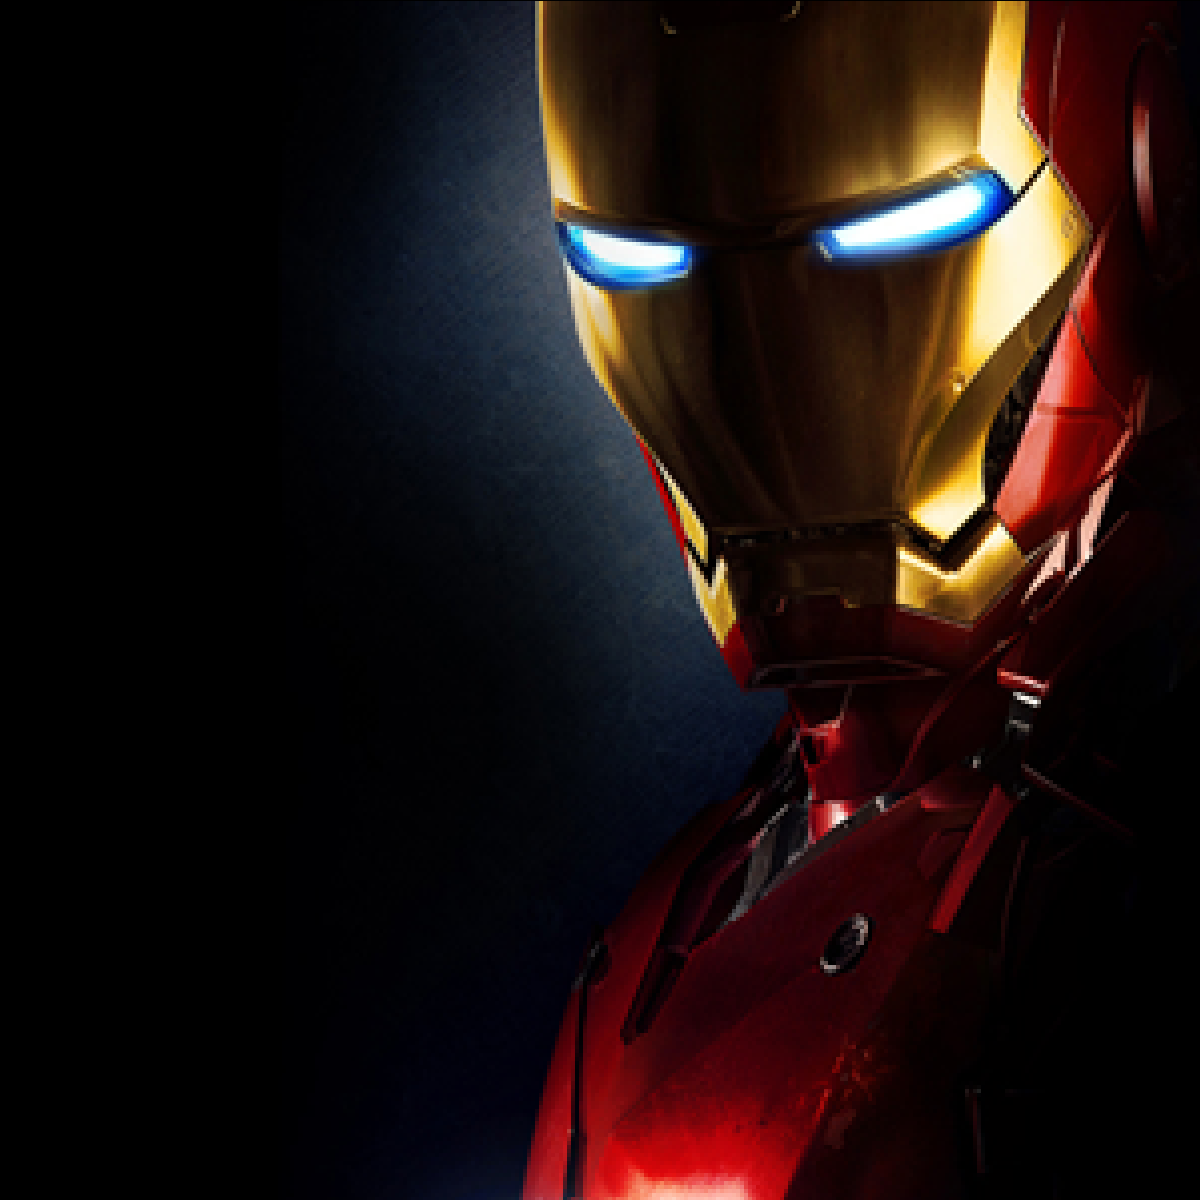

Ampliado 4x. Size: 1200x1200



In [ ]:
ironMan = 'ironman.png'
img = cv2.imread(sourcePath+ironMan)
w, h = img.shape[:2]; 
print(f'tamanho original: {w}x{h}')
cv2_imshow(img)
print()

def upscaling(img, s):
  w, h = img.shape[:2];
  xNew = int(w * s); 
  yNew = int(h * s); 
  xScale = xNew/(w-1); 
  yScale = yNew/(h-1);
  scaled = np.zeros([xNew, yNew, 3]);
  for i in range(xNew-1): 
    for j in range(yNew-1): 
      scaled[i + 1, j + 1]= img[1 + int(i / xScale), 1 + int(j / yScale)]
  return scaled

for s in range(2, 5):
  scaled = upscaling(img, s)
  cv2_imshow(scaled)
  w, h = scaled.shape[:2];
  print(f'Ampliado {s}x. Size: {w}x{h}\n')
                              

7. Escolha uma imagem interessante e gere uma pirâmide aplicando
sucessivamente downsampling 3 vezes com fator 1/2. Faça o mesmo com
uma pirâmide gaussiana e compare os resultados. Mostre os resultados de
cada pirâmide em uma única imagem lado a lado, como no slides 20 (vai
exigir algumas operações de translação de imagens). Obs.: aqui você pode usar funções do OpenCV.

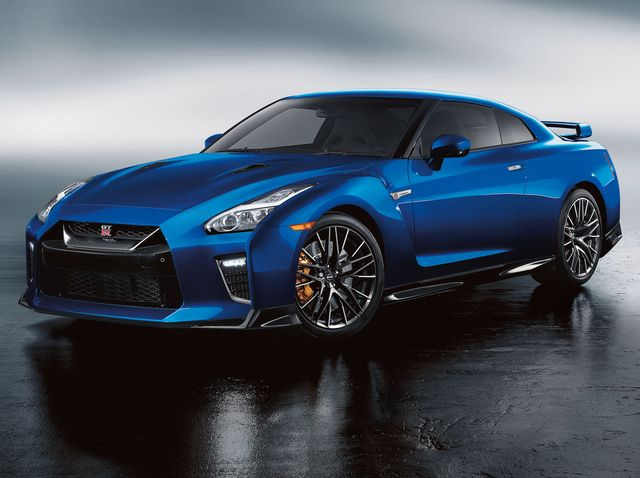


imagem original


In [ ]:

nissanGTR = '2023-nissan-gtr.jpg'
img = cv2.imread(sourcePath+nissanGTR)
cv2_imshow(img)
print()
print("imagem original")


In [ ]:
def downsample(image):
    m, n = image.shape[0], image.shape[1]
    y = np.arange(0, m, 2, np.int)
    x = np.arange(0, n, 2, np.int)
    a = image[y]
    b = a[:,x,:]
    return b  

In [ ]:
def piramide(image):
    if np.ndim(image) == 2:
        novo = np.zeros((image.shape[0],image.shape[1]*2), np.int)
    else:
        novo = np.zeros((image.shape[0],image.shape[1]*2,image.shape[2]), np.int)
        
    matriz = np.array([[1,0,0],[0,1,0],[0,0,0]])
    m, n = image.shape[0], image.shape[1]
    for i in range(4):
        for j in range(m):
            for k in range(n):
                r = np.array([j,k,1], np.int)
                X = np.dot(matriz, r)
                novo[X[0]][X[1]] = image[j][k]
        matriz[1][2] = matriz[1][2] + image.shape[1]
        image = downsample(image)
        m, n = image.shape[0], image.shape[1]
    return novo

<ipython-input-22-ad796991c0e8>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  novo = np.zeros((image.shape[0],image.shape[1]*2,image.shape[2]), np.int)
<ipython-input-22-ad796991c0e8>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional info

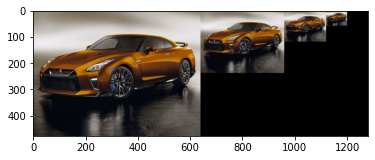

In [ ]:
u = piramide(img)
plt.imshow(u)

## **Pirâmide Gaussina**

In [ ]:
def generateGaussianKernel(size, cut_off):
    m = size//2
    u = np.linspace(-m, m, size)
    v = np.linspace(-m, m, size)
    a, b = np.meshgrid(u,v)
    kernel = np.exp((np.power(a,2) + np.power(b,2))*(-1)/(2*np.power(cut_off,2)))
    kernel = kernel * (1/(2*np.power(cut_off,2)*np.pi))
    return kernel

In [ ]:
def convolutionBW(src, kernel):
    m, n = kernel.shape
    y, x = src.shape
    border_size = m //2
    result = np.zeros((y,x), np.int)
    new_image = np.zeros((y + 2 * border_size, x + 2 * border_size), np.int)
    new_image[border_size:y+border_size,border_size:x+border_size] = src
    new_image[border_size:y+border_size,0:border_size] = src[0:y,0:border_size]
    new_image[border_size:y+border_size,x+border_size:x+border_size*2] = src[0:y,x-border_size:x]
    y, x = new_image.shape
    new_image[0:border_size, 0:x] = new_image[border_size:border_size*2, 0:x]
    new_image[y-border_size:y, 0:x] = new_image[y-border_size*2:y-border_size, 0:x]

    for j in range(border_size,y - border_size):
            for k in range(border_size, x - border_size):
                l = np.sum(new_image[j - border_size: j + border_size + 1,k - border_size:k + border_size + 1] * kernel)
                result[j-border_size][k-border_size] = l
    return result
    
def convolution(src, kernel):
    if np.ndim(src) == 2:
        return convolutionBW(src, kernel)
    else:
        m, n = kernel.shape
        y, x, d = src.shape
        q = m//2
        result = np.zeros((y,x,d), np.int)
        new_image = np.zeros((y + 2 * q, x + 2 * q, d), np.int)
        new_image[q:y+q,q:x+q,:] = src
        new_image[q:y+q,0:q,:] = src[0:y,0:q,:]
        new_image[q:y+q,x+q:x+q*2,:] = src[0:y,x-q:x,:]
        y, x, d = new_image.shape
        new_image[0:q, 0:x,:] = new_image[q:q*2, 0:x,:]
        new_image[y-q:y, 0:x,:] = new_image[y-q*2:y-q, 0:x,:]
        for i in range(d):
            for j in range(q,y - q):
                for k in range(q, x - q):
                    l = np.sum(new_image[j - q: j + q + 1,k - q:k + q + 1,i] * kernel)
                    result[j-q][k-q][i] = l
        return result

In [ ]:
def piramideGaussian(image):
    if np.ndim(image) == 2:
        novo = np.zeros((image.shape[0],image.shape[1]*2), np.int)
    else:
        novo = np.zeros((image.shape[0],image.shape[1]*2,image.shape[2]), np.int)
        
    matriz = np.array([[1,0,0],[0,1,0],[0,0,0]])
    m, n = image.shape[0], image.shape[1]
    kernel = generateGaussianKernel(7,1)
    for i in range(4):
        for j in range(m):
            for k in range(n):
                r = np.array([j,k,1], np.int)
                X = np.dot(matriz, r)
                novo[X[0]][X[1]] = image[j][k]
        matriz[1][2] = matriz[1][2] + image.shape[1]
        u = convolution(image, kernel)
        image = downsample(u)
        m, n = image.shape[0], image.shape[1]
    return novo

<ipython-input-26-4ae5836b1120>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  novo = np.zeros((image.shape[0],image.shape[1]*2,image.shape[2]), np.int)
<ipython-input-26-4ae5836b1120>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional info

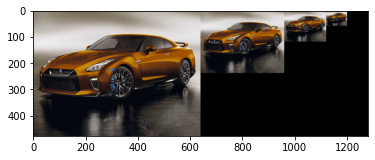

In [ ]:
sample = piramideGaussian(img)
plt.imshow(sample)

## **Comparação**

In [ ]:
f, axis = plt.subplots(2,1,figsize=(200,130))
axis[0].imshow(u, cmap='gray')
axis[1].imshow(sample, cmap='gray')

Output hidden; open in https://colab.research.google.com to view.

### **Comparação: downsampling aplicado 3 vezes com fator 1/2**

<ipython-input-21-997366800851>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.arange(0, m, 2, np.int)
<ipython-input-21-997366800851>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more 

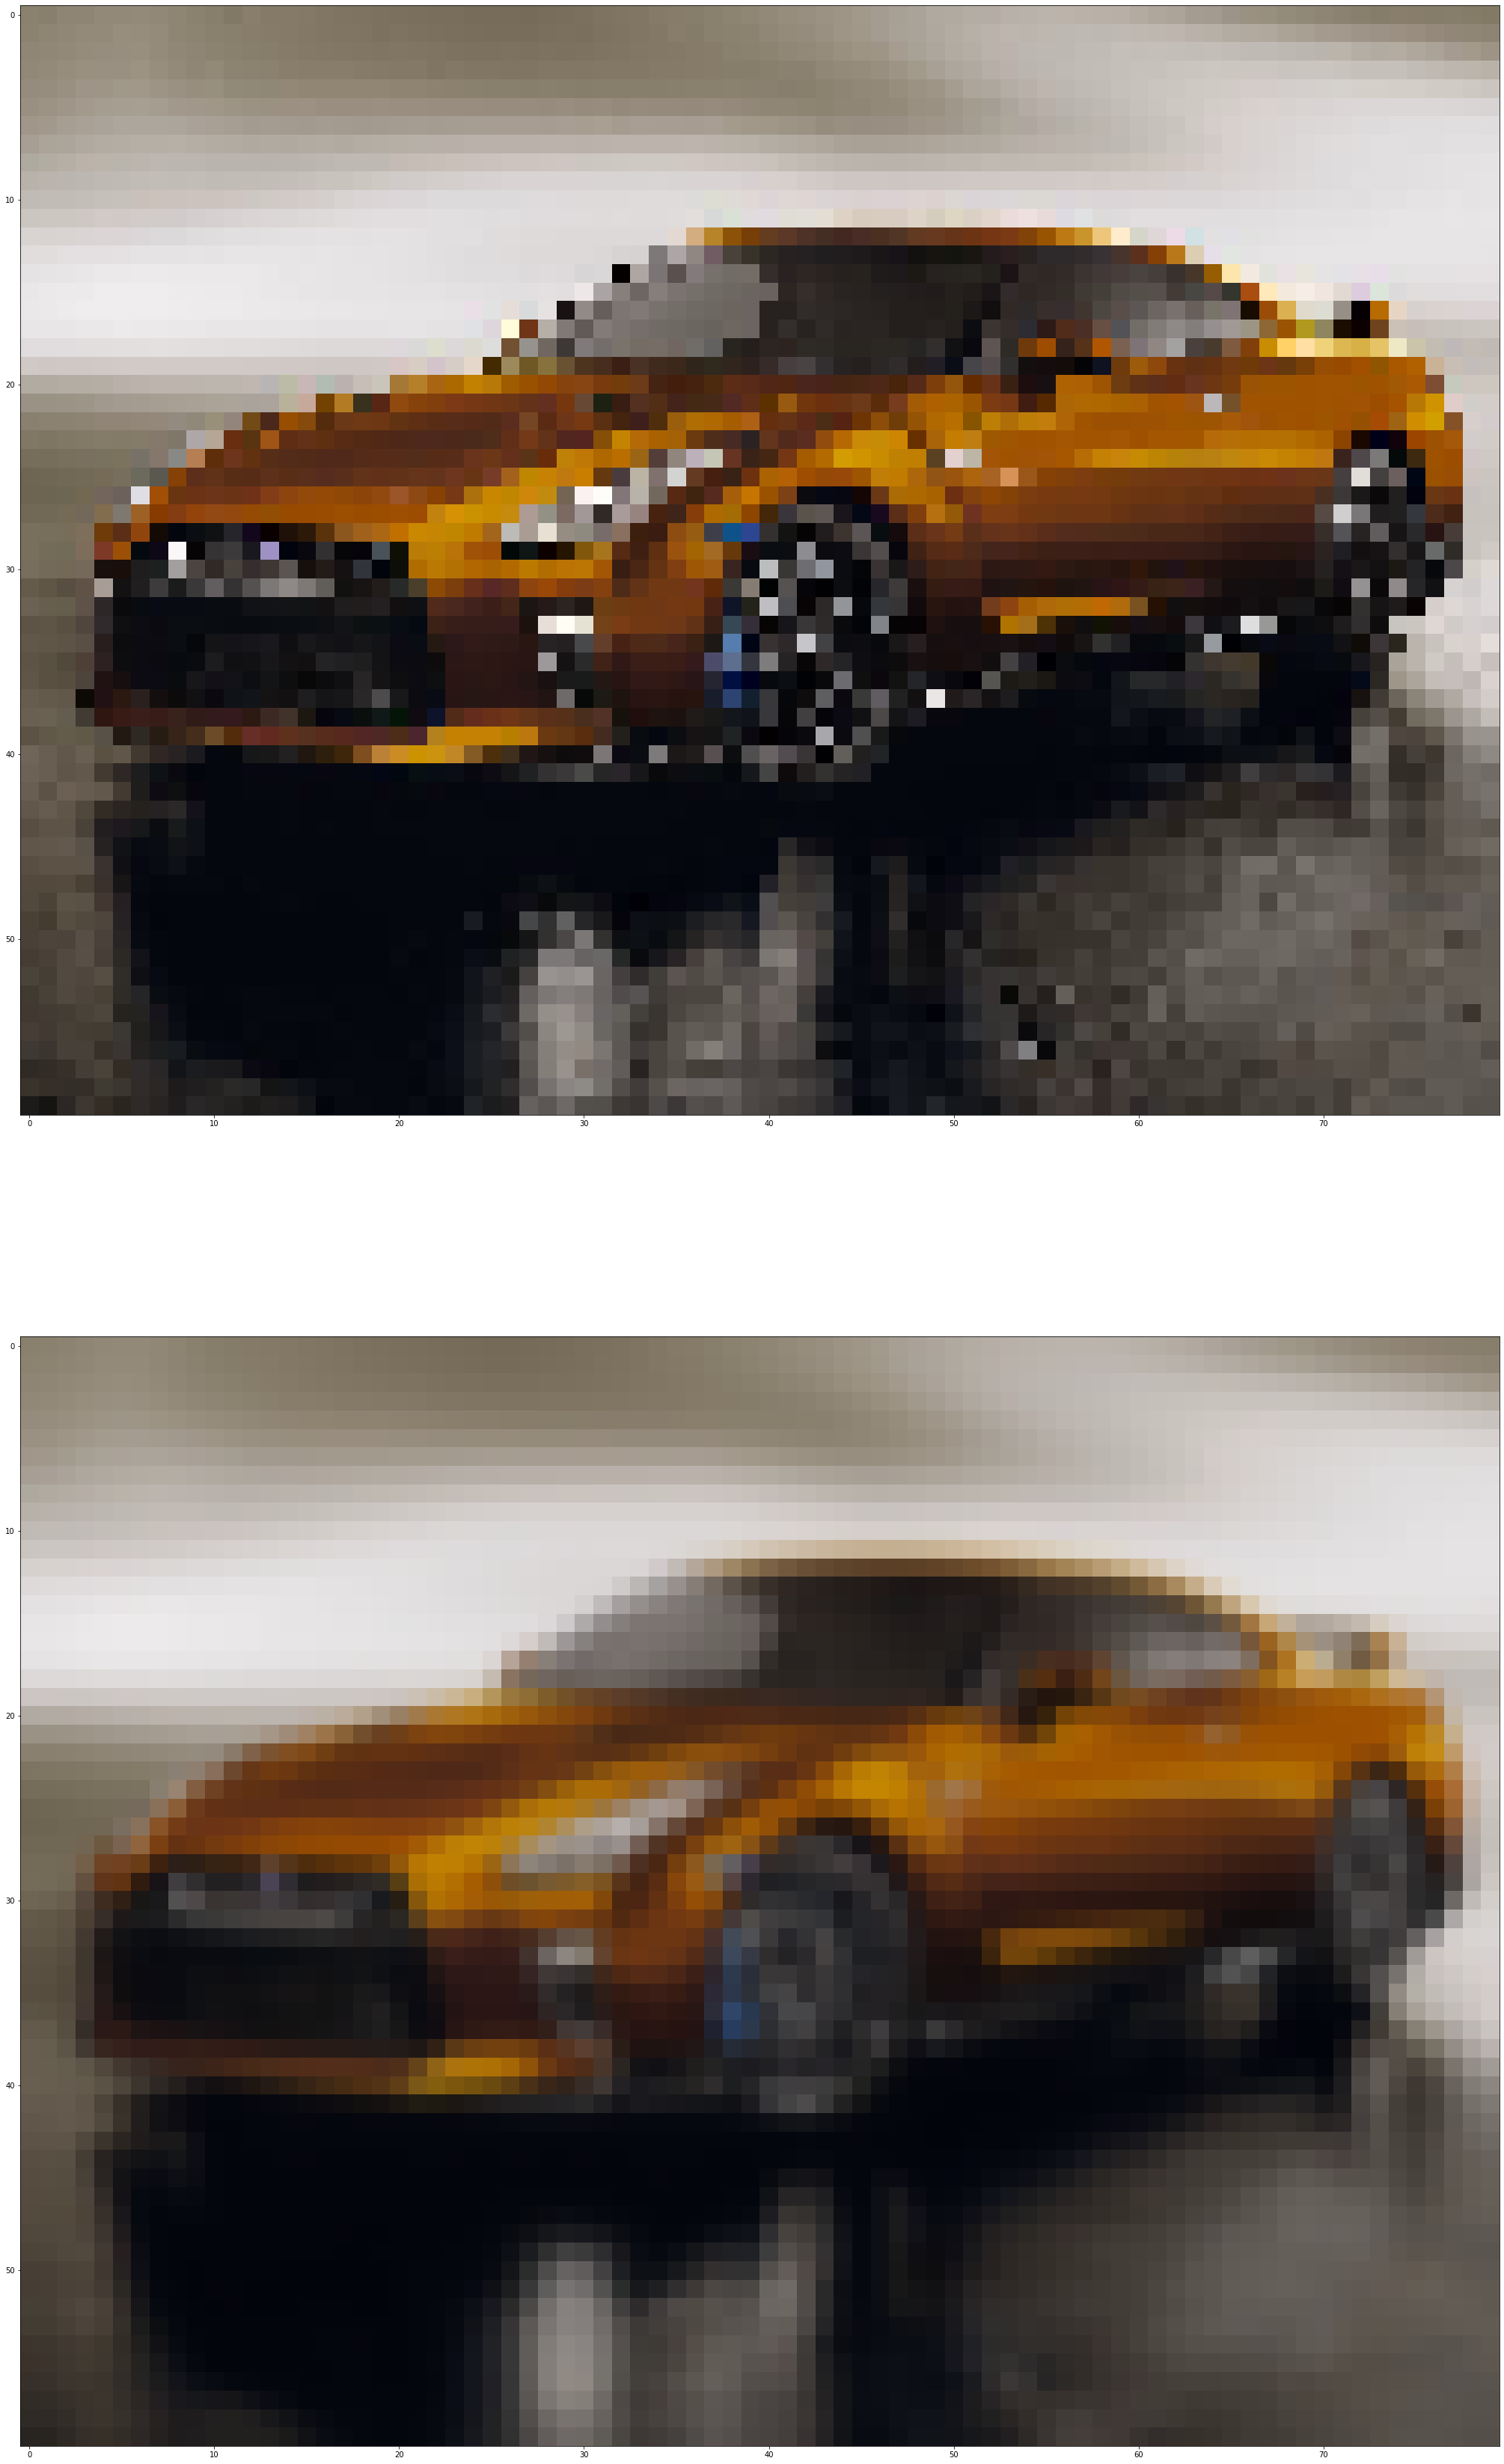

In [ ]:
a = img
b = img
kernel = generateGaussianKernel(7,1)
for i in range(3):
    a = downsample(a)
    b = convolution(b, kernel)
    b = downsample(b)
    
f, axis = plt.subplots(2,1,figsize=(60,60))
axis[0].imshow(a, cmap='gray')
axis[1].imshow(b, cmap='gray')

8. Usando a função da questão 1, crie funções que apliquem filtros
para calcular as imagens representando $\frac{∂f}{∂x}$ , $\frac{∂f}{∂y}$ e $|∇f|$. Em seguida, implemente o operador de Sobel usando estas imagens como entrada. Exiba cada um desses resultados para trˆes imagens distintas.